[3688.245361 3734.982422 3751.478271 3770.723877 3798.218018 3836.710449
 3888.95166  3971.439453 4103.420898 4342.620117 4861.999023 6566.594   ] Angstrom
8827
539 4501
8827


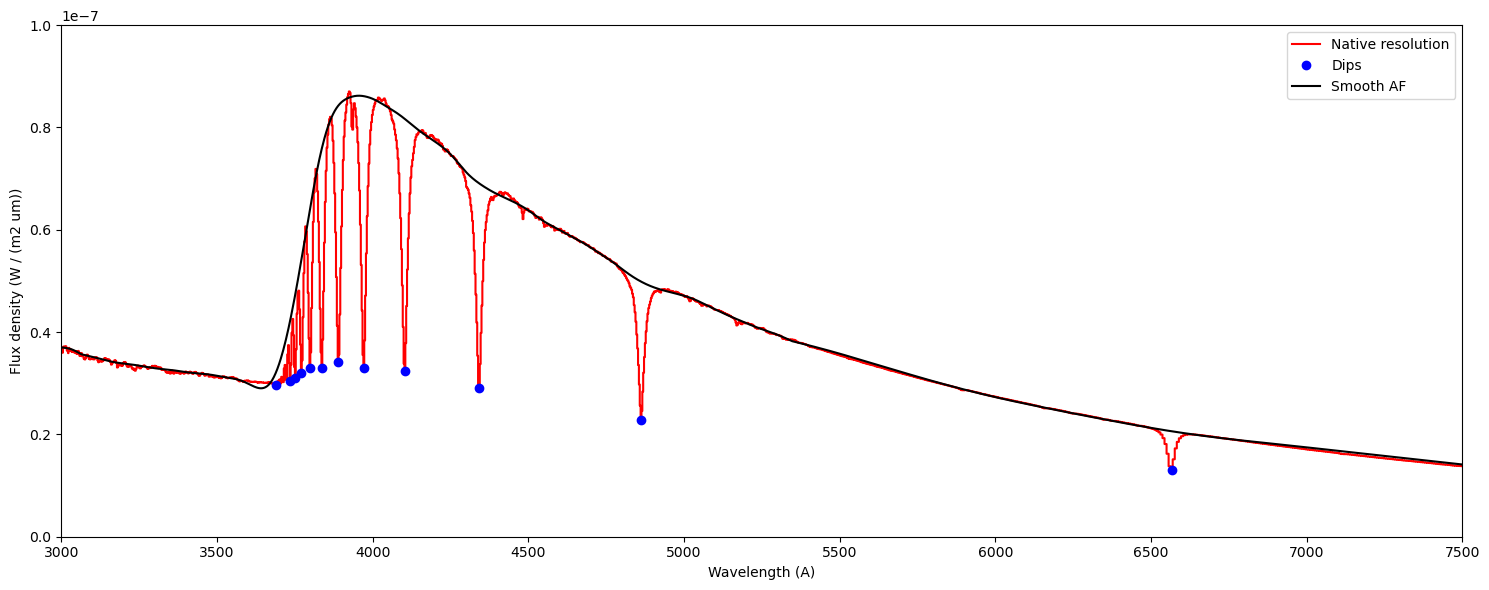

[1287031.27007497 1286965.09413214 1286842.01118077 ...  496209.55483589
  494423.42413448  492634.31444799] [3000.088623 3001.459229 3002.829834 ... 7480.168    7487.667
 7495.173   ]


In [1]:
#SBPY MODEL OF VEGA SPECTRUM
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from sbpy.calib import Vega
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.constants import h, c, k
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.interpolate import interp1d


# Create an array of wavelengths at R~25
wrange = 3000, 7500  # wavelength range
d = 1 + 1 / 25
n = int(np.ceil(np.log(wrange[1] / wrange[0]) / np.log(d)))
wave_binned = wrange[0] * d**np.arange(n) * u.AA
# Get the default solar spectrum, and rebin it
vega = Vega.from_default()

temperature = 10000

bin_width = 1
wavelength_range_angstrom = np.arange(3000, 7500+bin_width, bin_width)  # in Angstr

fluxd_binned = vega.observe(wavelength_range_angstrom*u.AA, unit='W / (m2 um)')


min_distance = 1
prominence = 1e-16

peaks, _ = find_peaks(vega.fluxd.to('W / (m2 um)'), distance=min_distance, prominence=prominence)
dips_vega, _ = find_peaks(-1*vega.fluxd.to('W / (m2 um)'), distance=min_distance, prominence=prominence*6e7)
dips_vega_w = vega.wave.to('AA')[dips_vega]
print(dips_vega_w[(dips_vega_w >= 3000* u.AA) & (dips_vega_w <= 7500* u.AA)])

new_intensity = vega.fluxd.to('W / (m2 um)')[peaks]

interpolator = interp1d(vega.wave.to('AA')[peaks], new_intensity, kind='linear', fill_value='extrapolate')
new_intensity_interpolated = interpolator(vega.wave.to('AA'))

print(len(new_intensity_interpolated))

new_intensity_savgol = savgol_filter(new_intensity_interpolated, window_length=50, polyorder=4)
new_intensity_savgol = savgol_filter(new_intensity_savgol, window_length=100, polyorder=2)

print(len(new_intensity), len(fluxd_binned))
print(len(vega.fluxd.to('W / (m2 um)')))
# Plot
plt.figure(figsize=(15, 6))
plt.plot(vega.wave.to('AA'), vega.fluxd.to('W / (m2 um)'), drawstyle='steps-mid', color='red', label='Native resolution')
plt.plot(vega.wave.to('AA')[dips_vega], vega.fluxd.to('W / (m2 um)')[dips_vega], 'bo', label='Dips')

plt.plot(vega.wave.to('AA'), new_intensity_savgol, linestyle='-', label='Smooth AF', color='black')


plt.setp(plt.gca(), xlim=wrange, xlabel='Wavelength (A)', ylabel='Flux density (W / (m2 um))', ylim=(0,1e-7))
plt.legend()
plt.tight_layout()
plt.show()

masky = vega.wave.to('AA')
mask = (masky >= 3000 * u.AA) & (masky <= 7500 * u.AA)

bins_model_vega = vega.wave.to('AA')[mask].value
spectra_model_vega = new_intensity_savgol[mask] * 3e6 / np.max(new_intensity_savgol)
print(spectra_model_vega, bins_model_vega)


In [2]:
#READING AND CROPPING IMAGES
#print(dont)
import numpy as np
from scipy.optimize import curve_fit
import csv
import imageio


def gaussian(x, amplitude, mean, stddev):
	return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)

def fit_gaussian(x, y):
	p0 = [np.max(y), np.argmax(y), 1.0]  # Initial guess for parameters
	popt, _ = curve_fit(gaussian, x, y, p0=p0)
	return popt

def calculate_fwhm(stddev):
	return 2 * np.sqrt(2 * np.log(2)) * stddev

data_path = '/mnt/AR-Drive-2/OpenLab/Spectroscope Data Observations/spectoscope/Vega/20_08_43'
output_path = '/output/'
stellar_source = 'Vega'
file_name_id = 'brjke'
num_of_images = 50

file_array = []
skip_indexes = [14, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]#, 45, 47, 48, 49, 50]

# Creating a CSV file for saving the cropped data
output_file_name = stellar_source + '-Data-Cropped.csv'
with open(output_file_name, 'w', newline='') as csvfile:
	fieldnames = ['file_number'] + [f'p{i}' for i in range(1, 1921)]
	writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
	writer.writeheader()
	
	for i in range(1, num_of_images + 1):
		
		if i in skip_indexes:
			continue
		
		print(i)
		file_name = '/' + file_name_id + '_' + str(f'{i:05}') + '.png'
		image = imageio.imread(data_path + file_name)

		intensity_values_along_y = np.sum(image, axis=0)
		
		intensity_values_along_x = np.sum(image, axis=1)

		y_values = np.arange(len(intensity_values_along_x))
		params = fit_gaussian(y_values, intensity_values_along_x)
		fit_curve = gaussian(y_values, *params)

		fwhm = calculate_fwhm(params[2])
		#print(f'Full Width at Half Maximum (FWHM): {fwhm}')

		# Extract pixel range within FWHM
		fwhm_range = np.where(fit_curve >= params[0] / 2)[0]
		min_pixel, max_pixel = fwhm_range[0], fwhm_range[-1]

		#print(f'Taking vertical pixel range within FWHM: {min_pixel-20} to {max_pixel+20}')

		cropped_image = image[min_pixel-20:max_pixel + 21, :]

		new_intensity_values_along_y = np.sum(cropped_image, axis=0)

		writer.writerow({
			'file_number': i,
			**{f'p{i}': val for i, val in enumerate(new_intensity_values_along_y, start=1)}
		})

1


/tmp/ipykernel_6297/709523442.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(data_path + file_name)
/home/royabhinav/anaconda3/lib/python3.11/site-packages/imageio/plugins/pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


2
3
4
5
6
7
8
9
10
11
12
13
15
16
17
18
19
20
21
22
23
24
25
26
27
44
45
46
47
48
49
50


In [3]:
#PLOTTING SPECTRA AND EXTRACTING DIPS DATA

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
from scipy.signal import savgol_filter



data_path = '/mnt/AR-Drive-2/OpenLab/Spectroscope Data Observations/spectoscope/Vega/20_08_43'
output_path = '/output/'
stellar_source = 'Vega'
file_name_id = 'brjke'
num_of_images = 50

calibration_coefficients = [-7.87006027e-05, -3.80749635e-02,  7.11501856e+02]

def calibrate_spectrum(pixel_positions):
	return np.polyval(calibration_coefficients, pixel_positions)

prominence = 1e5  # Adjust as needed

file_array = []

# Create and open a CSV file for saving the peaks
output_file_name_cropped_data = stellar_source + '-Data-Cropped.csv'

#print(df)
h_balmer_lines = [6563, 4861]
shift_wave = 250

df = pd.read_csv(output_file_name_cropped_data)

dips_wavelength_data = []


for index, row in df.iterrows():
	new_intensity_values_along_y = row.iloc[1:].values
	calibrated_wavelengths = 10 * calibrate_spectrum(range(len(new_intensity_values_along_y)))
	#print(calibrated_wavelengths)
	# Find dips in the specified wavelength ranges
	smoothed_intensity = savgol_filter(new_intensity_values_along_y, window_length=15, polyorder=4)
	new_intensity_values_along_y = smoothed_intensity

	# fig, axs = plt.subplots(len(h_balmer_lines)+1, 1, figsize=(10, 6 * len(h_balmer_lines)))

	final_dips = []
	dips_wavelengths = []

	for i, wavelength in enumerate(h_balmer_lines):
		min_wavelength, max_wavelength = wavelength - shift_wave, wavelength + shift_wave
		#print(min_wavelength,max_wavelength)

		indices_in_range = np.where((calibrated_wavelengths >= min_wavelength) & (calibrated_wavelengths <= max_wavelength))[0]
		#print(len(indices_in_range))
		min_distance = 100 #len(indices_in_range) - 100
		wavelength_range_for_line = calibrated_wavelengths[indices_in_range]
		intensity_values_along_y_new = new_intensity_values_along_y[indices_in_range]


		dips_in_range, _ = find_peaks(-intensity_values_along_y_new, distance=min_distance, prominence=prominence)
		dips_in_range = [dips_in_range[0]]
		#print(dips_in_range[0])
		#print(final_dips)

		lookup_wavelengths = [wavelength_range_for_line[pixel_position] for pixel_position in dips_in_range]

		lookup_indices = [np.argmin(np.abs(calibrated_wavelengths - wavelength)) for wavelength in lookup_wavelengths]
		final_dips.append(lookup_indices[0])
		dips_wavelengths.append({pixel_position: calibrated_wavelengths[pixel_position] for pixel_position in lookup_indices})
		# print(dips_wavelengths)

		# Plot and print dips within the specified range

	# 	axs[i].plot(wavelength_range_for_line, intensity_values_along_y_new, color='blue', label='Calibrated & Smoothed Spectrum')
	# 	axs[i].plot([wavelength_range_for_line[pixel_position] for pixel_position in dips_in_range], [intensity_values_along_y_new[pixel_position] for pixel_position in dips_in_range], 'ro', markersize=5, label='Detected Dips')
	# 	axs[i].set_title(f'Spectrum within {min_wavelength}-{max_wavelength} A')
	# 	axs[i].set_ylabel('Normalized Intensity')
	# 	axs[i].legend()
	# 	axs[i].grid(True)
	

	# axs[-1].plot(calibrated_wavelengths, new_intensity_values_along_y, color='blue', label='Calibrated & Smoothed Spectrum')
	# axs[-1].plot([calibrated_wavelengths[pixel_position] for pixel_position in final_dips], [new_intensity_values_along_y[pixel_position] for pixel_position in final_dips], 'ro', markersize=5, label='Detected Dips')
	# axs[-1].set_xlabel('Wavelength (A)')
	# axs[-1].set_ylabel('Normalized Intensity')
	# axs[-1].set_title(f'{stellar_source} Spectrum with Detected Dips (Absorption Features)')
	# axs[-1].legend()
	# axs[-1].grid(True)

	# plt.show()
	# plt.close()
		
	# print(row.iloc[0])
	# print(f'Detected Dips (Absorption Features) in Range:')
	# print(dips_wavelengths)
	extracted_wavelengths = [list(d.values())[0] for d in dips_wavelengths]
	#print(extracted_wavelengths)
	dips_wavelength_data.append({index: extracted_wavelengths})

#print(dips_wavelength_data)

flat_data = [{'Image': list(d.keys())[0], 'H-alpha': list(d.values())[0][0], 'H-beta': list(d.values())[0][1]} for d in dips_wavelength_data]

# Create a DataFrame from the flat_data
df_data2 = pd.DataFrame(flat_data)

output_file_name_dips_data = stellar_source + '-Data-Dips.csv'

df_data2.to_csv(output_file_name_dips_data, index=False)
#print(df_data2)


In [4]:
#OPTIMAL SHIFT CALCULATION

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

data_path = '/mnt/AR-Drive-2/OpenLab/Spectroscope Data Observations/spectoscope/Vega/20_08_43'
stellar_source = 'Vega'

output_file_name_dips_data = stellar_source + '-Data-Dips.csv'
df = pd.read_csv(output_file_name_dips_data)

h_balmer_lines = [6563, 4861]

#print(df)

# Extract relevant data from the DataFrame
image_numbers = df['Image'].values
observed_h_alpha = df['H-alpha'].values
observed_h_beta = df['H-beta'].values

# Initial guess for wavelength shifts (zeros for each image)
initial_shifts = np.zeros(len(image_numbers))

# Define a cost function (chi-squared) to minimize
def cost_function(shift):
    expected_h_alpha = observed_h_alpha + shift
    expected_h_beta = observed_h_beta + shift
    chi_squared = np.sum(((6563 - expected_h_alpha)**2 / 6563) + ((4861 - expected_h_beta)**2 / 4861))
    return chi_squared

# Minimize the cost function to find optimal shifts
result = minimize(cost_function, initial_shifts, method='L-BFGS-B')

# Extract the optimal shifts
optimal_shifts = result.x

#print(optimal_shifts)
df['Optimal Shift'] = optimal_shifts
df.to_csv(output_file_name_dips_data, index=False)

print(df)


# Plot the results
# plt.plot(image_numbers, optimal_shifts, marker='o', linestyle='-', color='b')
# plt.xlabel('Image Number')
# plt.ylabel('Optimal Wavelength Shift in A')
# plt.title('Optimal Wavelength Shift for Stacking (Balmer Series)')
# plt.show()



    Image      H-alpha       H-beta  Optimal Shift
0       0  6441.950796  4650.969124     172.168403
1       1  6447.956581  4673.406949     156.722634
2       2  6461.377517  4679.000665     147.798340
3       3  6468.778502  4698.529091     133.430205
4       4  6489.291918  4731.826955     105.572325
5       5  6495.096229  4731.826955     103.102438
6       6  6496.543372  4737.354562      99.311147
7       7  6496.543372  4740.116005      97.724811
8       8  6497.988941  4742.875874      95.524120
9       9  6503.755476  4753.899609      86.738408
10     10  6508.063850  4764.898161      78.585468
11     11  6516.638100  4781.348767      65.486353
12     12  6525.155685  4789.552821      57.148850
13     13  6535.021251  4811.361042      40.422376
14     14  6529.393229  4814.079986      41.255154
15     15  6533.616606  4816.797357      37.896972
16     16  6542.020863  4816.797357      34.320908
17     17  6537.825818  4819.513153      34.545656
18     18  6537.825818  4814.07

/home/royabhinav/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/royabhinav/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/royabhinav/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_6297/196385293.py:100: RuntimeWarning: invalid value encountered in divide
  global_mean_intensity = global_intensity_sum / global_bins


{17: 3383, 39: 3405, 56: 3422, 83: 3449, 93: 3459, 161: 3528, 224: 3591, 365: 3732, 406: 3773, 1488: 4855, 1836: 5203, 2289: 5656, 2437: 5804, 2774: 6141, 2859: 6226, 3053: 6420, 3214: 6581, 3623: 6990, 3780: 7147}


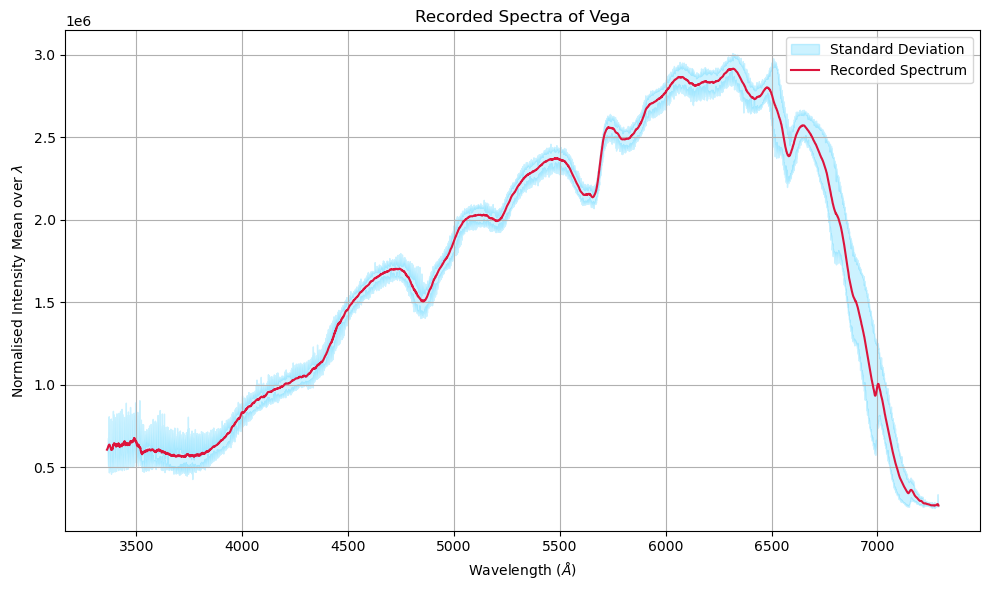

651 3922


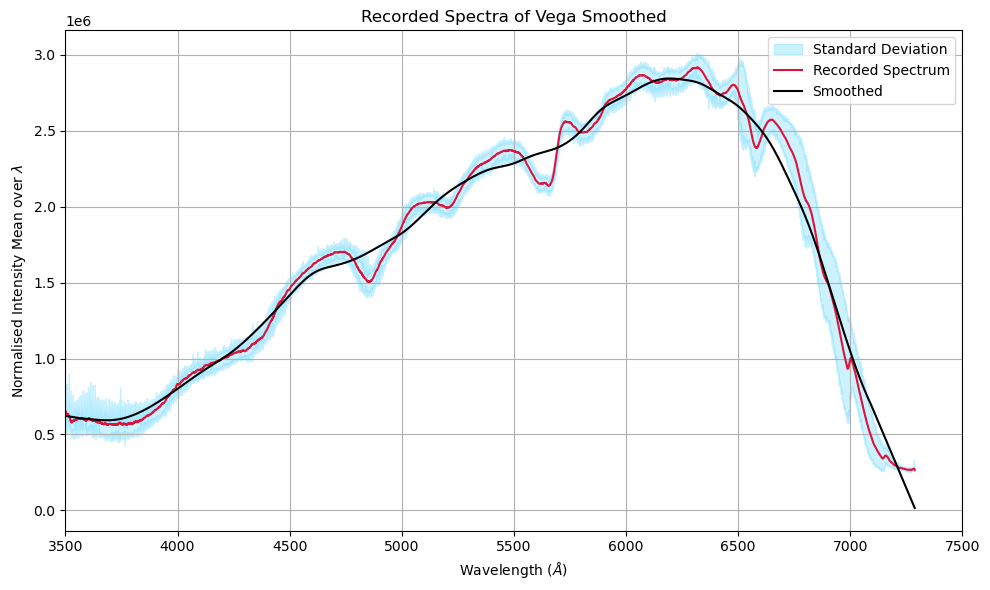

[690318.51989019 690068.53453657 689818.54918295 ...  24573.50760976
  20890.54505287  17207.58249597] [3362 3365 3367 ... 7286 7287 7288]


In [5]:
#PLOTTING SPECTRA AND EXTRACTING DIPS DATA

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
from scipy.signal import savgol_filter



data_path = '/mnt/AR-Drive-2/OpenLab/Spectroscope Data Observations/spectoscope/Vega/20_08_43'
stellar_source = 'Vega'


calibration_coefficients = [-7.87006027e-05, -3.80749635e-02,  7.11501856e+02]

def calibrate_spectrum(pixel_positions):
	return np.polyval(calibration_coefficients, pixel_positions)

min_distance = 10  # Adjust as needed
prominence = 1e4  # Adjust as needed

file_array = []

# Create and open a CSV file for saving the peaks
output_file_name_cropped_data = stellar_source + '-Data-Cropped.csv'
df = pd.read_csv(output_file_name_cropped_data)

#print(df)

output_file_name_cropped_data = stellar_source + '-Data-Cropped.csv'
df_spectra = pd.read_csv(output_file_name_cropped_data)

output_file_name_dips_data = stellar_source + '-Data-Dips.csv'
df_dips = pd.read_csv(output_file_name_dips_data)


optimal_shifts = df_dips['Optimal Shift'].values

# Create bins
bin_width = 1
bins = np.arange(3000, 7500+bin_width, bin_width)  # Adjust bin width as needed5
#print(bins)
global_bins = np.zeros(len(bins) - 1)
global_intensity_sum = np.zeros(len(bins) - 1)
bin_intensity_values = [[] for _ in range(len(bins) - 1)]


for index, row in df_spectra.iterrows():
	new_intensity_values_along_y = row.iloc[1:].values
	new_intensity_values_along_y = new_intensity_values_along_y * 3 * 1e6 / np.max(new_intensity_values_along_y)
	
	calibrated_wavelengths = 10 * calibrate_spectrum(range(len(new_intensity_values_along_y)))
	#smoothed_intensity = savgol_filter(new_intensity_values_along_y, window_length=50, polyorder=10)
	#new_intensity_values_along_y = smoothed_intensity

	spec_shift = optimal_shifts[index]
	calibrated_wavelengths = calibrated_wavelengths + spec_shift

	# dips, _ = find_peaks(-new_intensity_values_along_y, distance=min_distance, prominence=prominence)
	# dips_wavelengths = {pixel_position: calibrated_wavelengths[pixel_position] for pixel_position in dips}

	# Use numpy.digitize to find bin indices for each wavelength
	bin_indices = np.digitize(calibrated_wavelengths, bins, right=True)

	for i, bin_index in enumerate(bin_indices):
		if bin_index > 0 and bin_index < len(bins):
			global_bins[bin_index - 1] += 1
			global_intensity_sum[bin_index - 1] += new_intensity_values_along_y[i]
			bin_intensity_values[bin_index - 1].append(new_intensity_values_along_y[i])

	#print(global_bins)
	# if index == 0:
	# 	plt.figure(figsize=(10, 6))
	# 	plt.plot(calibrated_wavelengths, new_intensity_values_along_y, color='blue', label='Calibrated Spectrum')
	# 	plt.plot([calibrated_wavelengths[pixel_position] for pixel_position in dips], [new_intensity_values_along_y[pixel_position] for pixel_position in dips], 'ro', markersize=5, label='Detected Dips')
	# 	plt.xlabel('Wavelength (nm)')
	# 	plt.ylabel('Intensity')
	# 	plt.title('Star Spectrum with Detected Dips (Absorption Features)')
	# 	plt.legend()
	# 	plt.grid(True)
	# 	plt.show()
	# 	plt.close()

	# 	print(index)
	# 	print('Detected Dips (Absorption Features):')
	# 	for pixel_position, wavelength in dips_wavelengths.items():
	# 		print(f'Pixel Position: {pixel_position}, Wavelength: {wavelength} nm')
	# 	print()

# Print counts for each bin
# print("Global Bin Counts:")
# print(global_bins)
# print(global_intensity_sum/global_bins)

bin_std_dev = [np.std(values) for values in bin_intensity_values]
bin_std_dev = np.array(bin_std_dev)

bins = bins[:-1] + bin_width
global_mean_intensity = global_intensity_sum / global_bins
global_mean_intensity = np.nan_to_num(global_mean_intensity, nan=0, posinf=0, neginf=0)
non_zero_mask = global_mean_intensity != 0
global_mean_intensity = global_mean_intensity[non_zero_mask]
bins = bins[non_zero_mask]
bin_std_dev = bin_std_dev[non_zero_mask]

smooth = savgol_filter(global_mean_intensity, window_length=30, polyorder=5)
#smooth = savgol_filter(smooth, window_length=80, polyorder=4)
dips, _ = find_peaks(-smooth, distance=min_distance, prominence=prominence)
dips_wavelengths = {pixel_position: bins[pixel_position] for pixel_position in dips}
print(dips_wavelengths)
# Plot global intensity sum normalized by the number of points in each bin
plt.figure(figsize=(10,6))
plt.fill_between(bins, global_mean_intensity - bin_std_dev, global_mean_intensity + bin_std_dev, color='deepskyblue', alpha=0.2, label='Standard Deviation')

#plt.plot(bins, global_mean_intensity,'b.', label='Mean Normalised Spectrum',markersize=3)
plt.plot(bins, smooth,color='crimson', linestyle='solid', label='Recorded Spectrum')
#plt.plot([bins[pixel_position] for pixel_position in dips], [smooth[pixel_position] for pixel_position in dips], 'ro', markersize=5.5, label='Detected Dips')



plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Normalised Intensity Mean over $\lambda$')
plt.title('Recorded Spectra of Vega')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

min_distance = 1
prominence = 1e-1

peaks, _ = find_peaks(smooth, distance=min_distance, prominence=prominence)
print(len(peaks), len(smooth))

new_intensity = smooth[peaks]

interpolator = interp1d(bins[peaks], new_intensity, kind='linear', fill_value='extrapolate')
new_intensity_interpolated = interpolator(bins)

new_intensity_savgol = savgol_filter(new_intensity_interpolated, window_length=200, polyorder=2)
new_intensity_savgol = savgol_filter(new_intensity_savgol, window_length=400, polyorder=1)

plt.figure(figsize=(10,6))
plt.fill_between(bins, global_mean_intensity - bin_std_dev, global_mean_intensity + bin_std_dev, color='deepskyblue', alpha=0.2, label='Standard Deviation')
plt.plot(bins, smooth,color='crimson', linestyle='solid', label='Recorded Spectrum')
#plt.plot([bins[pixel_position] for pixel_position in dips], [smooth[pixel_position] for pixel_position in dips], 'ro', markersize=5.5, label='Detected Dips')

plt.plot(bins, new_intensity_savgol, linestyle='-', label='Smoothed', color='black')


plt.setp(plt.gca(), xlim=(3500,7500), xlabel='Wavelength ($\AA$)', ylabel='Normalised Intensity Mean over $\lambda$', title='Recorded Spectra of Vega Smoothed')# ylim=(0,1e-7))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

bins_obs_vega = bins
spectra_obs_vega = new_intensity_savgol * 3e6 / np.max(new_intensity_savgol)
print(spectra_obs_vega, bins_obs_vega)

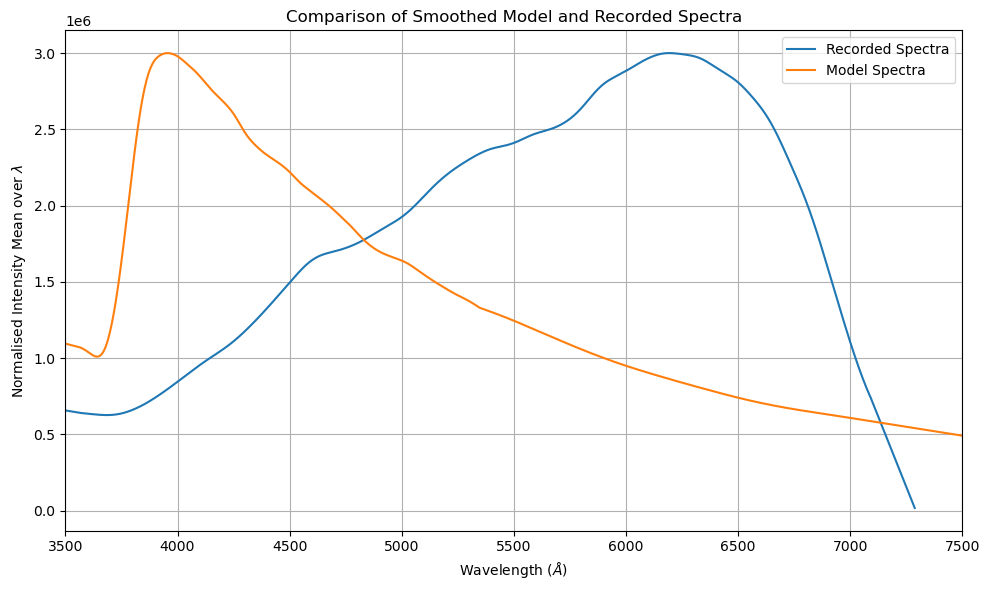

In [6]:
plt.figure(figsize=(10,6))
plt.plot(bins_obs_vega,spectra_obs_vega,label='Recorded Spectra')
plt.plot(bins_model_vega,spectra_model_vega,label='Model Spectra')
plt.setp(plt.gca(), xlim=(3500,7500), xlabel='Wavelength ($\AA$)', ylabel='Normalised Intensity Mean over $\lambda$', title='Comparison of Smoothed Model and Recorded Spectra')# ylim=(0,1e-7))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

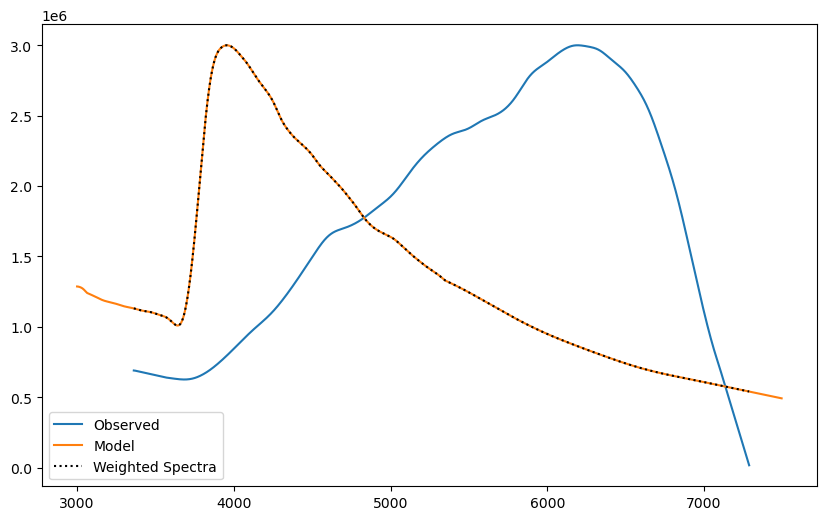

In [10]:
import numpy as np
from scipy.interpolate import interp1d


def resample_1_to_2(bins_1, spectra_1, bins_2):
	interp_func = interp1d(bins_1, spectra_1, kind='linear', fill_value='extrapolate')
	
	spectra_1_resampled = interp_func(bins_2)
	
	return spectra_1_resampled

resampled_model = resample_1_to_2(bins_model_vega, spectra_model_vega, bins_obs_vega)

def calculate_weights(observed, model):
	weights = model / observed
	
	return weights

weights = calculate_weights(spectra_obs_vega, resampled_model)


weighted_spectra = weights * spectra_obs_vega 

plt.figure(figsize=(10, 6))
plt.plot(bins_obs_vega, spectra_obs_vega,'-', label='Observed')
plt.plot(bins_model_vega, spectra_model_vega,'-', label='Model')
plt.plot(bins_obs_vega, weighted_spectra, label='Weighted Spectra', linestyle=':', color='black')
plt.legend()
plt.show()

[1.64201309 1.64207705 1.64214101 ... 3.43837938 3.46867296 3.49896654]


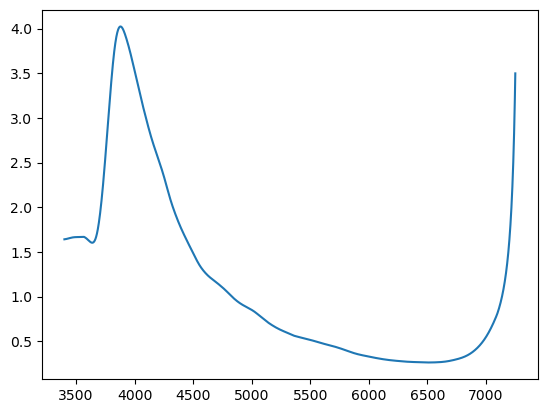

In [11]:
import numpy as np
from scipy.interpolate import interp1d


def resample_weights(bins_obs, weight_vega, wavelength_range_obs):
	interp_func = interp1d(bins_obs, weight_vega, kind='linear', fill_value='extrapolate')

	weights_resampled = interp_func(wavelength_range_obs)
	
	return weights_resampled
	

wavelength_range_obs = np.linspace(3400,7250,10000)
new_weights = resample_weights(bins_obs_vega, weights, wavelength_range_obs)
print(new_weights)

plt.plot(wavelength_range_obs, new_weights)

data_to_save = np.column_stack((wavelength_range_obs, new_weights))
np.savetxt('sensor-weight-data.csv', data_to_save, delimiter=',', header='Wavelength(A),Weight', comments='')
